## Setup

We'll be using a modified version of the Frozen Lake environment to Q-learning.  This notebook is adapted from Homework 2 of UC Berkeley's Spring 2017 Deep Reinforcement Learning course [http://rll.berkeley.edu/deeprlcourse/]. We use the same modified version of the MDP that we used in value iteration, policy iteration, etc. Note we add rewards of -0.001 to each transition to maintain a comparison with the other algorithms.

In [9]:
from frozen_lake import FrozenLakeEnv
env = FrozenLakeEnv()

In [10]:
# Some basic imports and setup
%matplotlib inline
import numpy as np, numpy.random as nr, gym
import matplotlib.pyplot as plt
from MDP import MDP

In [241]:
ALPHA=1   #Discount factor
nIt = 50  #Number of iterations to run each algorithm
transient = [0,1,2,3,4,6,8,9,10,13,14] #Transient (non-terminal) states

In [242]:
#Represent environment as MDP object
mdp = MDP( {s : {a : [list(tup[:3]) for tup in tups] for (a, tups) in a2d.items()} for (s, a2d) in env.P.items()}, env.nS, env.nA, transient, env.desc)

In [253]:
for s in mdp.P.keys(): 
    if s in transient:
        for a in mdp.P[s].keys(): 
            for t in mdp.P[s][a]:
                if t[1] in mdp.transient: 
                    t[2] = -0.001

In [254]:
import dill
with open('FrozenLakeMDP.pkl', 'wb') as output:
  dill.dump(mdp, output)

And we are set up!

## Testing ##

In [445]:
def compute_Qmu(alpha, J_mu, mdp):
    '''
    Returns Qmu, an mdp.nS x mdp.nA array representing the Q function at
    cost vector J 
    '''
    Qmu = np.array([[sum([l[0]*(l[2] + alpha*J_mu[l[1]]) for l in mdp.P[s][a]]) for a in range(mdp.nA)] for s in range(mdp.nS)])    
    return Qmu

def value_iteration(alpha, mdp, nIt):
    J_k = np.zeros(mdp.nS)   #Initialize cost
    Js = [J_k]               #Lists to collect iterates
    mus = []
    for it in range(nIt):
        Qmu = compute_Qmu(alpha, J_k, mdp)
        J_k, mu_k =  np.max(Qmu,axis=1), np.argmax(Qmu, axis=1)
        Js.append(J_k)
        mus.append(mu_k)
    return np.array(Js), np.array(mus), Qmu
Js_VI, mus_VI, Qmu = value_iteration(ALPHA, mdp, 10000)

In [446]:
Qmu

array([[ 0.845,  0.846,  0.83 ,  0.843],
       [ 0.758,  0.166,  0.737,  0.827],
       [ 0.819,  0.772,  0.804,  0.818],
       [ 0.735,  0.163,  0.727,  0.809],
       [ 0.849,  0.774,  0.171,  0.761],
       [ 0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.177,  0.762,  0.177,  0.654],
       [ 0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.774,  0.183,  0.863,  0.862],
       [ 0.789,  0.974,  0.861,  0.181],
       [ 0.954,  0.892,  0.175,  0.706],
       [ 0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.196,  0.891,  0.991,  0.877],
       [ 0.987,  0.994,  0.995,  0.961],
       [ 0.   ,  0.   ,  0.   ,  0.   ]])

## Q($\lambda$)

Now we'll cover Watkin's Q($\lambda$) from section 7.6 in the book. To align with the plotting from previous algorithms we need to store the value function iterates. Since we are only working with the $Q$ function, we can recover the rewards?-to-go vector $J$ for a state (under some policy) using the relationship $J(s)= \arg \max_{a} Q(s,a)$. We can run this algorithm multiple times until convergence. 

In [447]:
def Q_lambda(mdp, lambda_ = 0.5, alpha = 0.5, step_exponent = 0, gamma = 0.9, epsilon = 0.9, episodes = 20):
    
    # initialize Q-table
    Q = np.random.rand(mdp.nS, mdp.nA)*2 - 0.5
    Q = np.zeros((mdp.nS, mdp.nA))
    
    # initialize traces
    ETrace = np.zeros((mdp.nS, mdp.nA))
    
    # lists to collect iterates
    J_k = np.zeros(mdp.nS)
    Js_Q = [J_k]             
    mus = []
    RMSE = []
    
    # other helper variables
    probs = [epsilon, 1-epsilon]
    actions = [l for l in range(mdp.nA)]
    
    for i in range(episodes):
        # while loop initializations
        s, a, a_next, s_next = [0, 0, 0, 0] 
        a = np.random.randint(0, mdp.nA)
        step_size = alpha*(i+1)**step_exponent
        
        while s in mdp.transient:
            s_next, r = mdp.step(s, a)
            a_star = np.argmax(Q[s_next])
            # pick epsilon greedy action
            a_next = np.random.choice([ a_star, np.random.choice([a for a in actions if a != a_star]) ],
                                     p = probs)

            
            # tie-breaker
            if Q[s_next][a_next] == Q[s_next][a_star]:
                a_star = a_next
            

            # compute step
            delta = r + gamma*Q[s_next][a_star] - Q[s][a]
            # update eligibility traces
            ETrace[s][a] = ETrace[s][a] + 1
            
            # update Q function
            Q = Q + step_size*delta*ETrace

            # update eligibility trace
            ETrace = gamma*lambda_*ETrace

            
            if a_star == a_next:
                ETrace = gamma*lambda_*ETrace
            else:
                ETrace = np.zeros((mdp.nS, mdp.nA))
            

            # update data
            J_k, mu_k =  np.max(Q, axis = 1), np.argmax(Q, axis = 1)
            Js_Q.append(J_k)
            mus.append(mu_k)

            s = s_next
            a = a_next
            
        RMSE.append(np.linalg.norm(Q - Qmu))
        
    return np.array(Js_Q), np.array(mus), Q, RMSE


lambda_, alpha, step_exponent, gamma, epsilon = [0.4, 0.99, -0.50001, 0.9, 0.9]
Js_Q, mus_Q, Q, RMSE = Q_lambda(mdp, lambda_, alpha, step_exponent, gamma, epsilon, episodes = 10000)
print('Done!')

Done!


## Plots ##

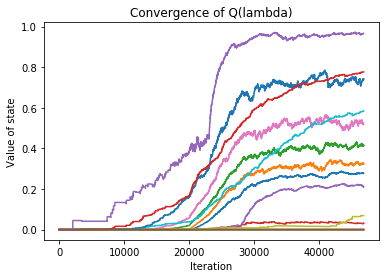

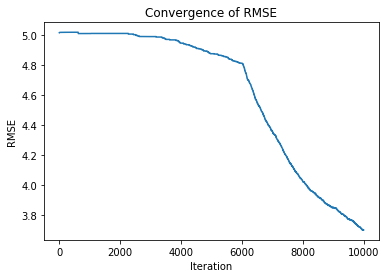

In [448]:
plt.title('Convergence of Q(lambda)')
plt.xlabel('Iteration')
plt.ylabel('Value of state')
plt.plot(Js_Q)
plt.show()


plt.title('Convergence of RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.plot(RMSE)
plt.show()

## Convergence in Policies ##

In [450]:
def plot_policy(env, Js, mus, nIt=7):
    n = Js.shape[0]
    every = int(np.floor(n/10))
    start = every - 1
    for (J, mu) in zip(Js[start:n:every], mus[start:n:every]):
        plt.figure(figsize=(3,3))
        plt.imshow(J.reshape(4,4), cmap='gray', interpolation='none', clim=(0,1))
        ax = plt.gca()
        ax.set_xticks(np.arange(4)-.5)
        ax.set_yticks(np.arange(4)-.5)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        Y, X = np.mgrid[0:4, 0:4]
        a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(-1, 0)}
        Mu = mu.reshape(4,4)
        for y in range(4):
            for x in range(4):
                a = Mu[y, x]
                u, v = a2uv[a]
                plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
                plt.text(x, y, str(env.desc[y,x].item().decode()),
                         color='g', size=12,  verticalalignment='center',
                         horizontalalignment='center', fontweight='bold')
        plt.grid(color='b', lw=2, ls='-')

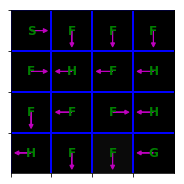

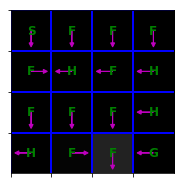

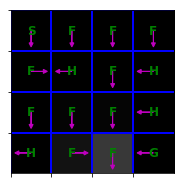

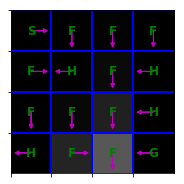

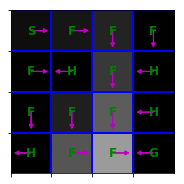

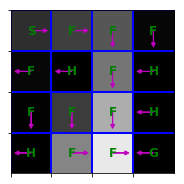

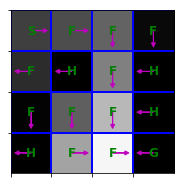

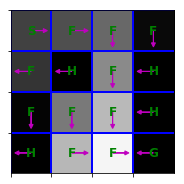

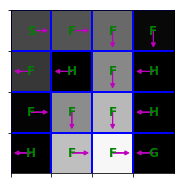

In [451]:
plot_policy(env, Js_Q, mus_Q)

## More Plots ##
Lastly, we can see how this performs when using different tuning parameters:

In [ ]:
# grab last RMSE for each setting and plot

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

plt.title('Convergence of RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.plot(RMSE)
plt.show()